In [188]:
using LaTeXStrings
using JLD2
using LinearAlgebra
using Statistics
using DifferentialEquations
using Random
using ArgParse
using Plots
using Interpolations
BLAS.set_num_threads(1)

In [85]:
function sampleSpinZPlus(n)
    θ = fill(acos(1 / sqrt(3)), n)
    ϕ = 2π * rand(n)                  
    return θ, ϕ
end
function sampleSpinZMinus(n)
    θ = fill(π - acos(1 / sqrt(3)), n)   
    ϕ = 2π * rand(n)                  
    return θ, ϕ
end
function prob_func(prob, i, repeat)
    u0 = Vector{Float64}(undef, 2 * nAtoms)
    θ_plus, ϕ_plus = sampleSpinZPlus(nAtoms)
    u0[1:nAtoms] = θ_plus
    u0[nAtoms.+(1:nAtoms)] = ϕ_plus
    return remake(prob, u0=u0)
end
function get_neighbors_vectorized(nAtoms)
    matrix_size = sqrt(nAtoms) |> Int
    rows = [(div(i - 1, matrix_size) + 1) for i in 1:nAtoms]
    cols = [(mod(i - 1, matrix_size) + 1) for i in 1:nAtoms]
    neighbor_offsets = [
        (-1, 0),  # Up
        (1, 0),   # Down
        (0, -1),  # Left
        (0, 1)    # Right
    ]
    neighbors = Vector{Vector{Int}}(undef, nAtoms)
    for i in 1:nAtoms
        row, col = rows[i], cols[i]
        atom_neighbors = [
            (row + dr - 1) * matrix_size + (col + dc)
            for (dr, dc) in neighbor_offsets
            if 1 <= row + dr <= matrix_size && 1 <= col + dc <= matrix_size
        ]
        neighbors[i] = atom_neighbors
    end
    return neighbors
end

get_neighbors_vectorized (generic function with 1 method)

### SDEs from PHYSICAL REVIEW RESEARCH 4, 043136 (2022)

In [86]:
# function drift!(du, u, p, t)
#     Ω, Δ, V, Γ, γ = p
#     sqrt_3 = sqrt(3)
    
#     # Extract θ and ϕ
#     θ = u[1:nAtoms]
#     ϕ = u[nAtoms+1:2*nAtoms]
    
#     # Compute dϕ_drift_sum using loops (all-to-all interaction)
#     dϕ_drift_sum = zeros(nAtoms)
#     for n in 1:nAtoms
#         sum_term = 0.0
#         for m in 1:nAtoms
#             if m != n
#                 distance = abs(m - n)
#                 interaction = (1 - sqrt_3 * cos(θ[m])) / (distance^6)
#                 sum_term += interaction
#             end
#         end
#         dϕ_drift_sum[n] = sum_term
#     end
    
#     # # Compute trigonometric terms
#     # cotθ = cot.(θ)
#     # cscθ = csc.(θ)
    
#     # # Drift for θ (equation 62a)
#     # dθ_drift = -2 .* Ω .* sin.(ϕ) .+ Γ .* (cotθ .- cscθ ./ sqrt_3)
    
#     # # Drift for ϕ (equation 62b, keeping Δ for now)
#     # dϕ_drift = -(2 .* Ω .* cotθ .* cos.(ϕ) .+ (V / 2) .* dϕ_drift_sum .- Δ)
    
#     # # Assign to du
#     # du[1:nAtoms] .= dθ_drift
#     # du[nAtoms+1:2*nAtoms] .= dϕ_drift

#     # Pre-allocate arrays
#     cotθ = zeros(nAtoms)
#     cscθ = zeros(nAtoms)
#     dθ_drift = zeros(nAtoms)
#     dϕ_drift = zeros(nAtoms)

#     # Compute trigonometric terms and drifts using for loops
#     for i in 1:nAtoms
#         # Compute trigonometric terms
#         cotθ[i] = cot(θ[i])
#         cscθ[i] = csc(θ[i])
        
#         # Drift for θ (equation 62a)
#         dθ_drift[i] = -2 * Ω * sin(ϕ[i]) + Γ * (cotθ[i] - cscθ[i] / sqrt_3)
        
#         # Drift for ϕ (equation 62b, keeping Δ for now)
#         dϕ_drift[i] = -(2 * Ω * cotθ[i] * cos(ϕ[i]) + (V / 2) * dϕ_drift_sum[i] - Δ)
        
#         # Assign to du
#         du[i] = dθ_drift[i]
#         du[nAtoms + i] = dϕ_drift[i]
#     end
# end

# function diffusion!(du, u, p, t)
#     # Ω, Δ, V, Γ, γ = p
#     # θ = u[1:nAtoms]
#     # sqrt_3 = sqrt(3)
#     # term1 = 1
#     # term2 = 2 .* cot.(θ) .^ 2
#     # term3 = 2 .* cot.(θ) .* csc.(θ) ./ sqrt_3
#     # diffusion = sqrt.(Γ .* (term1 .+ term2 .- term3) .+ 4 .* γ)
#     # du[1:nAtoms] .= 0.0
#     # du[nAtoms.+(1:nAtoms)] .= diffusion

#     Ω, Δ, V, Γ, γ = p
#     θ = u[1:nAtoms]
#     sqrt_3 = sqrt(3)
#     diffusion = zeros(nAtoms)  # Pre-allocate diffusion array
#     du[1:nAtoms] .= 0.0        # Still okay to vectorize this initialization

#     for i in 1:nAtoms
#         term1 = 1
#         term2 = 2 * cot(θ[i])^2
#         term3 = 2 * cot(θ[i]) * csc(θ[i]) / sqrt_3
#         diffusion[i] = sqrt(Γ * (term1 + term2 - term3) + 4 * γ)
#         du[nAtoms + i] = diffusion[i]
#     end
# end

### SDEs from this project

In [175]:
function drift!(du, u, p, t)
    neighbors = get_neighbors_vectorized(nAtoms)
    Ω, Δ, V, Γ, γ = p
    θ = u[1:nAtoms]
    ϕ = u[nAtoms .+ (1:nAtoms)]
    sqrt_3 = sqrt(3)
    dϕ_drift_sum = zeros(nAtoms)
    if case == 1
        dϕ_drift_sum[2:end-1] .= 2 .+ sqrt_3 .* (cos.(θ[1:end-2]) .+ cos.(θ[3:end]))
        dϕ_drift_sum[1] = 1 + sqrt_3 * cos(θ[2]) 
        dϕ_drift_sum[end] = 1 + sqrt_3 * cos(θ[end-1])
    end
    if case == 2
        for n in 1:nAtoms
            neighbor_indices = neighbors[n]
            dϕ_drift_sum[n] = sum(1 .+ sqrt_3 * cos.(θ[neighbor_indices]))
        end
    end
    cotθ = cot.(θ)
    cscθ = csc.(θ)
    dθ_drift = -2 .* Ω .* sin.(ϕ) .+ Γ .* (cotθ .+ cscθ ./ sqrt_3)
    dϕ_drift = -2 .* Ω .* cotθ .* cos.(ϕ) .+ (V / 2) .* dϕ_drift_sum .- Δ
    du[1:nAtoms] .= dθ_drift
    du[nAtoms .+ (1:nAtoms)] .= dϕ_drift
end

function diffusion!(du, u, p, t)
    Ω, Δ, V, Γ, γ = p
    θ = u[1:nAtoms]
    sqrt_3 = sqrt(3)
    term1 = 9 / 6
    term2 = (4 * sqrt_3 / 6) .* cos.(θ)
    term3 = (3 / 6) .* cos.(2 .* θ)
    cscθ2 = csc.(θ) .^ 2
    dominant_term = Γ .* (term1 .+ term2 .+ term3) .* cscθ2
    small_term = 4 .* γ
    # Use logarithmic form: sqrt(x + y) = exp(0.5 * log(x + y))
    arg = dominant_term .+ small_term
    diffusion = exp.(0.5 .* log.(max.(arg, eps(Float64))))
    du[1:nAtoms] .= 0.0
    du[nAtoms .+ (1:nAtoms)] .= diffusion
end

diffusion! (generic function with 1 method)

In [206]:
function computeTWA(nAtoms, tf, nT, nTraj, dt, Ω, Δ, V, Γ, γ)
    tspan = (0, tf)
    tSave = LinRange(0, tf, nT)
    u0 = Vector{Float64}(undef, 2 * nAtoms)
    p = (Ω, Δ, V, Γ, γ, nAtoms)

    prob = SDEProblem(drift!, diffusion!, u0, tspan, p)
    ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
    
    sol = solve(ensemble_prob, SRIW1(), EnsembleThreads();
        saveat=tSave, trajectories=nTraj, maxiters=1e+7, dt=dt,
        abstol=1e-3, reltol=1e-3)
    
    return tSave, sol
end

function compute_spin_Sz(sol, nAtoms)
    θ = sol[1:nAtoms, :, :]
    Szs = sum(sqrt(3) * cos.(θ),dims=1)
    return Szs
end

compute_spin_Sz (generic function with 1 method)

In [207]:
# PHYSICAL REVIEW RESEARCH 4, 043136 (2022)
# V = 1
# γ = 0.01 * V
# Γ = 0.01 * V
# Ω_values = 0.3 * V
# Δ = 0

# From this project and from PHYSICAL REVIEW RESEARCH 6, 013052 (2024)
Γ = 1
γ = 0.001 * Γ
Δ = 400 * Γ
Ω_values = 1
V = Δ

# no decay + dephasing for testing if SDEs and systems are implemented correctly
# Γ = 0
# γ = 0 * Γ
# V = 1
# Δ = 0 * Γ


nAtoms = 400
tf = 10
nT = 400
nTraj = 1
dt = 1e-2
case = 2

# Case-specific parameters
if case == 1
    Ω_values = 0:2:10
else
    Ω_values = 0:1:20
end

script_dir = @__DIR__

@time begin
       data_folder = joinpath(script_dir, "results_data/atoms=$(nAtoms),Δ=$(Δ),γ=$(γ)")
        # If folder exists, delete it and recreate it
        if isdir(data_folder)
            rm(data_folder, recursive=true)  # Delete the folder and all its contents
        end
        mkpath(data_folder)  # Create the folder anew
        println("Computing for nAtoms = $(nAtoms)...\n")
        for Ω in Ω_values
            println("Computing for Ω = $(Ω)")
            @time t, sol = computeTWA(nAtoms, tf, nT, nTraj, dt, Ω, Δ, V, Γ, γ)
            @save "$(data_folder)/sz_mean_steady_for_$(case)D,Ω=$(Ω),Δ=$(Δ),γ=$(γ).jld2" t sol
        end
end

Computing for nAtoms = 400...

Computing for Ω = 0
  8.770585 seconds (120.39 M allocations: 6.050 GiB, 14.61% gc time, 0.25% compilation time)
Computing for Ω = 1
 15.514741 seconds (222.30 M allocations: 11.169 GiB, 14.92% gc time)
Computing for Ω = 2
 18.142885 seconds (265.76 M allocations: 13.353 GiB, 14.89% gc time)
Computing for Ω = 3
 21.210460 seconds (308.77 M allocations: 15.513 GiB, 14.72% gc time)
Computing for Ω = 4
 23.352783 seconds (339.27 M allocations: 17.045 GiB, 14.88% gc time)
Computing for Ω = 5
 26.268035 seconds (374.83 M allocations: 18.832 GiB, 14.88% gc time)
Computing for Ω = 6
 27.781971 seconds (386.92 M allocations: 19.439 GiB, 14.72% gc time)
Computing for Ω = 7
 29.128748 seconds (402.76 M allocations: 20.235 GiB, 14.67% gc time)
Computing for Ω = 8
 26.900039 seconds (378.56 M allocations: 19.019 GiB, 14.51% gc time)
Computing for Ω = 9
 26.128735 seconds (364.16 M allocations: 18.296 GiB, 14.72% gc time)
Computing for Ω = 10
 26.844871 seconds (374.5

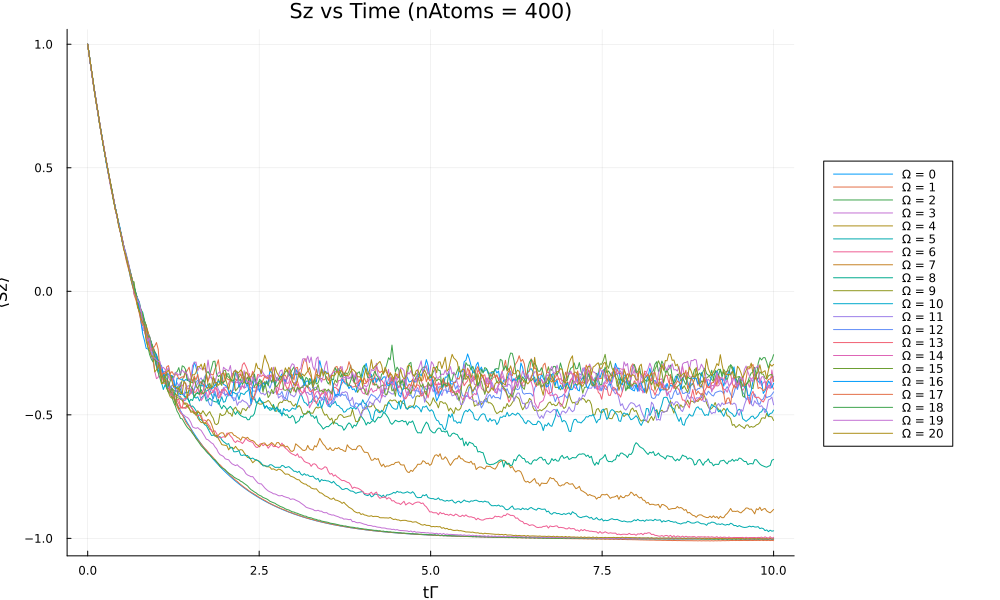

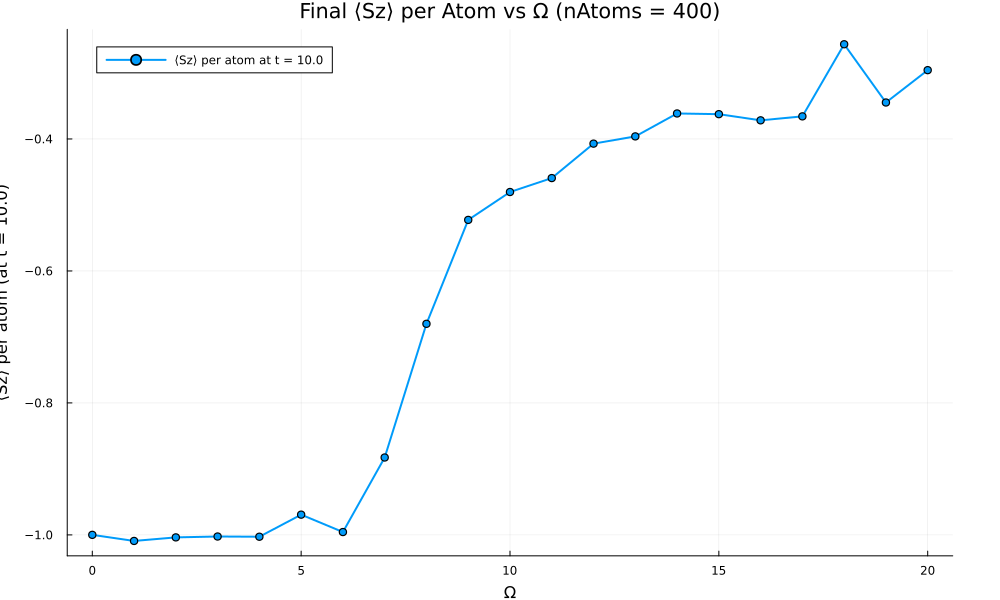

"/Users/hoangnguyen/ResearchProj/TWA/Rydberg_facilitation/Final_Sz_vs_Ω_nAtoms=400,γ=0.001.png"

In [210]:
# Extract the time array 't' from the first file (assuming t is the same for all Ω)
# Load the first file to get t
first_Ω = first(Ω_values)
first_file = "$(data_folder)/sz_mean_steady_for_$(case)D,Ω=$(first_Ω),Δ=$(Δ),γ=$(γ).jld2"
first_data = load(first_file)
t = first_data["t"]  # Define t outside the loop

# Initialize an empty plot for time evolution
plt1 = plot(
    xlabel="tΓ", 
    ylabel="⟨Sz⟩", 
    title="Sz vs Time (nAtoms = $nAtoms)", 
    legend=:outerright,  # Legend outside the plot
    size=(1000, 600),    # Set plot size to 1000x600 pixels (width, height)
    right_margin=10Plots.mm  # Add space for the legend
)

# Arrays to store the last values of ⟨Sz⟩ per atom for the second plot
Sz_last_values = Float64[]

# Loop over Ω_values to load and plot saved data
for (i, Ω) in enumerate(Ω_values)
    file = "$(data_folder)/sz_mean_steady_for_$(case)D,Ω=$(Ω),Δ=$(Δ),γ=$(γ).jld2"
    data = load(file)
    t = data["t"]  # This is now redundant since we defined t above, but kept for consistency
    sol = data["sol"]
        
    # Compute Szs
    Szs = compute_spin_Sz(sol, nAtoms)
        
    # Average over trajectories and normalize by nAtoms
    Szs_mean = dropdims(mean(Szs, dims=3), dims=3) / nAtoms  # ⟨Sz⟩ per atom
        
    # Extract the last value of ⟨Sz⟩ per atom for this Ω
    Sz_last = Szs_mean[1, end]  # Last value in the time series
    push!(Sz_last_values, Sz_last)
        
    # Add to the time evolution plot (plot every 5th Ω to reduce clutter)
    plot!(plt1, t, Szs_mean[1, :], label="Ω = $Ω")
end

# Display the first plot (time evolution)
display(plt1)

# Save the first plot with γ and nAtoms in the filename
savefig(plt1, "Final_Sz_vs_tΓ_nAtoms=$nAtoms,γ=$γ.png")

# Create the second plot: Last value of ⟨Sz⟩ per atom vs Ω
plt2 = plot(
    Ω_values, 
    Sz_last_values, 
    marker=:circle, 
    label="⟨Sz⟩ per atom at t = $(t[end])", 
    linewidth=2,
    xlabel="Ω", 
    ylabel="⟨Sz⟩ per atom (at t = $(t[end]))", 
    title="Final ⟨Sz⟩ per Atom vs Ω (nAtoms = $nAtoms)",
    # legend=:lowerright,  # Legend outside the plot
    size=(1000, 600),    # Same size as the first plot
    right_margin=10Plots.mm
)

# Display the second plot
display(plt2)

# Save the second plot with γ and nAtoms in the filename
savefig(plt2, "Final_Sz_vs_Ω_nAtoms=$nAtoms,γ=$γ.png")

In [ ]:
using QuantumOptics
using LinearAlgebra
using Plots

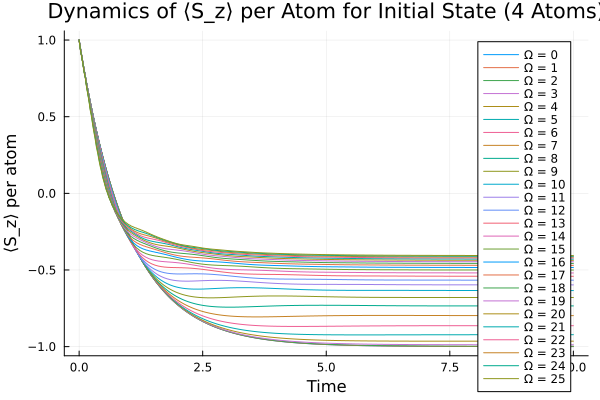

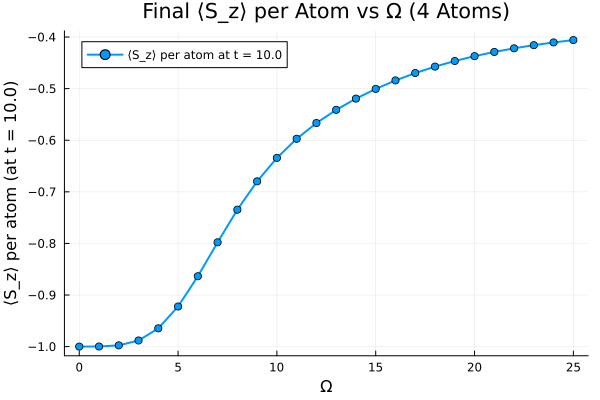

In [114]:
# Step 1: Define system parameters
N = 4              # Number of atoms
Γ = 1.0            # Decay rate
γ = 0.001 * Γ         # Dephasing rate
Δ = 400 * Γ        # Detuning
V = Δ              # Nearest-neighbor interaction strength (C_6 / r^6)
Ω_values = 0:1:25 # Rabi frequency range
tf = 10.0          # Final time
nT = 400           # Number of time points
tspan = range(0, tf, length=nT)

# Step 2: Set up the basis
basis = SpinBasis(1//2)
# Composite basis for 4 atoms
basis_total = tensor([basis for _ in 1:N]...)

# Step 3: Define operators for a single atom
sp = QuantumOptics.sigmap(basis)  # σ^+ = |r⟩⟨g|
sm = QuantumOptics.sigmam(basis)  # σ^- = |g⟩⟨r|
sz = QuantumOptics.sigmaz(basis)  # σ^z
sigr = 0.5 * (sz + identityoperator(basis))  # σ^rr = |r⟩⟨r|

# Embed operators into the composite Hilbert space for each atom
sp_ops = [embed(basis_total, i, sp) for i in 1:N]
sm_ops = [embed(basis_total, i, sm) for i in 1:N]
sigr_ops = [embed(basis_total, i, sigr) for i in 1:N]
sz_ops = [embed(basis_total, i, sz) for i in 1:N]

# Step 4: Define the initial state |r, r, r, r⟩
r = spinup(basis)    # |r⟩
psi0 = tensor([r for _ in 1:N]...)  # |r, r, r, r⟩
rho0 = dm(psi0)      # Density matrix |r, r, r, r⟩⟨r, r, r, r|

# Step 5: Define the Hamiltonian
function hamiltonian(Ω)
    # Laser driving term: Ω ∑_i (σ_i^gr + σ_i^rg)
    laser = zero(sp_ops[1])
    for i in 1:N
        laser += Ω * (sm_ops[i] + sp_ops[i])
    end
    
    # Interaction and detuning terms
    interaction = zero(sigr_ops[1])
    detuning = zero(sigr_ops[1])
    for i in 1:N
        # Detuning term: -Δ σ_i^rr
        detuning += -Δ * sigr_ops[i]
        
        # Nearest-neighbor interaction: V σ_i^rr σ_j^rr for |i-j|=1
        for j in 1:N
            if abs(i - j) == 1  # Nearest neighbors in 1D lattice
                interaction += V * sigr_ops[i] * sigr_ops[j]
            end
        end
    end
    
    return laser + interaction + detuning
end

# Step 6: Define Lindblad operators
# Decay: √Γ σ_i^gr, Dephasing: √γ σ_i^rr for each atom
J = vcat([sqrt(Γ) * sm_ops[i] for i in 1:N], [sqrt(γ) * sigr_ops[i] for i in 1:N])

# Step 7: Define S_z operator
Sz = sum(sz_ops)

# Step 8: Solve the master equation for each Ω
Sz_per_atom = zeros(length(Ω_values), nT)

for (i, Ω) in enumerate(Ω_values)
    H = hamiltonian(Ω)
    tout, rho_t = timeevolution.master(tspan, rho0, H, J)
    # Compute ⟨S_z⟩ and divide by N to get per-atom value
    Sz_per_atom[i, :] = real(expect(Sz, rho_t)) / N
end

# Step 9: Plot the time evolution of ⟨S_z⟩ per atom
plot()
for (i, Ω) in enumerate(Ω_values)
    plot!(tspan, Sz_per_atom[i, :], label="Ω = $(Ω_values[i])")
end
xlabel!("Time")
ylabel!("⟨S_z⟩ per atom")
title!("Dynamics of ⟨S_z⟩ per Atom for Initial State (4 Atoms)")
display(plot!())
Sz_last = Sz_per_atom[:, end]  # Last column of Sz_per_atom (at t = tf)
# Step 11: Plot the last value of ⟨S_z⟩ per atom vs Ω
plot(Ω_values, Sz_last, marker=:circle, label="⟨S_z⟩ per atom at t = $tf", linewidth=2)
xlabel!("Ω")
ylabel!("⟨S_z⟩ per atom (at t = $tf)")
title!("Final ⟨S_z⟩ per Atom vs Ω (4 Atoms)")
display(plot!())